## Table of Contents

1. [Datasets](#1)<br>
2. [Total Imprisonment Rates](#2)<br>
    2a. [Visualization Pitfall](#3)<br>
    2b. [Population Dataset](#4)<br>
    2c. [Visualization Breakthrough, Observations, and interactive maps](#5)<br>
3. [State Imprisonment Distributions by Gender](#6)<br>
    3a. [Static Scatter Plots with Distributions](#7)<br>
    3b. [Interactive Scatter Plots](#8)<br>    
4. [Summary](#8)<br>

[Previous Notebook: Part 1]

## Datasets <a id="1"></a>

As in part 1, I'm exploring the most recent data from the Bureau of Justice Statistics' [Prisoner Series datasets](http://www.bjs.gov/index.cfm?ty=pbdetail&iid=6187).

## Imprisonment Counts and Rates by State (Table p16t02) <a id="2"></a>

In the previous post, Exploratory Data Analysis Part 1, we saw that the vast majority of people in prisons are in state prisons, but we didn't discover anything about imprisonment rates in individual states. One of my favorite tools for examining geographical data is the **choropleth map** (which you may recognize from any recent [election night](https://www.nytimes.com/elections/results/california)). In this post, I use the Bokeh python package to generate some state-level choropleths to show rates of imprisonment and how they vary from state to state. 

Scroll to the bottom if you want to jump straight to the maps.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from IPython.core.display import display, HTML
import os
%matplotlib inline

In [2]:
# Notebook Styling 
# pd.options.display.max_columns = None
# display(HTML("<style>.container { width:100% !important; }</style>"))
# pd.set_option('display.float_format',lambda x: '%.5f' % x)
# plt.rcParams['figure.figsize'] = 10,10

In [3]:
# Importing modules from a visualization package.
from bokeh.sampledata.us_states import data as states
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.models import LinearColorMapper, ColorBar, BasicTicker
try:
    del states["HI"]
    del states["AK"]
except KeyError:
    pass

In [4]:
# This dictionary maps State names to State Codes
def get_state_code():
    state_code = {
        'United States': 'US',
        'Alabama': 'AL',
        'Alaska': 'AK',
        'American Samoa': 'AS',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Guam': 'GU',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'National': 'NA',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Northern Mariana Islands': 'MP',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Puerto Rico': 'PR',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virgin Islands': 'VI',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'
    }
    return state_code

In [5]:
# Breakdown by State and Gender (Table p16t02)
CSV_PATH = os.path.join('data', 'prison', 'p16t02.csv')
state_sex_df = pd.read_csv(CSV_PATH, encoding='latin1',
                           header=[11,12], na_values=':',
                           thousands=r',')
# display(state_sex_df)
state_sex_df.dropna(axis=0, thresh=5, inplace=True)
state_sex_df.dropna(axis=1, thresh=5, inplace=True)
# state_sex_df.dropna(axis=0, inplace=True)
state_sex_df.drop(['Percent change, 20152016', 'Unnamed: 12_level_0',
                   'Unnamed: 14_level_0'],
                  axis=1, inplace=True)
state_sex_df.drop([0,1,2], axis=0, inplace=True)  
state_sex_df.head()

C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,Unnamed: 1_level_0,2015,Unnamed: 3_level_0,Unnamed: 4_level_0,2016,Unnamed: 7_level_0,Unnamed: 8_level_0
,Unnamed: 1_level_1,Total,Male,Female,Total,Male,Female
3,Alabama,30810.0,28220.0,2590.0,28883.0,26506.0,2377.0
4,Alaska/c,5338.0,4761.0,577.0,4434.0,4024.0,410.0
5,Arizona,42719.0,38738.0,3981.0,42320.0,38323.0,3997.0
6,Arkansas,17707.0,16305.0,1402.0,17537.0,16161.0,1376.0
7,California,129593.0,123808.0,5785.0,130390.0,124487.0,5903.0


In [6]:
# Fixing the headers for the dataframe
tmp1 = ['Area'] 
tmp1.extend(3*[state_sex_df.columns.values[1][0]])
tmp1.extend(3*[state_sex_df.columns.values[4][0]])
tmp2 = [el[1] for el in state_sex_df.columns.values]
tmp2[0] = ''
state_sex_df.columns = pd.MultiIndex.from_arrays([tmp1,tmp2], names=['', ''])
state_sex_df.reset_index(drop=True, inplace=True)

# To clean up the '/_' footnote indicators
fix = lambda x: x.split('/')[0]
state_sex_df['Area'] = state_sex_df['Area'].apply(fix)

# This creates a new column in the DataFrame with the state code for each state
state_code = get_state_code()
map_state_codes = lambda x: state_code[x]
state_sex_df['Code'] = state_sex_df['Area'].apply(map_state_codes)
state_sex_df.drop(['Area'], axis=1, inplace=True)  # drops the row with aggregated values
# This sets the state code as the index
state_sex_df.set_index('Code', inplace=True)

# This fixes the names of the columns (to facilitate merging later)
state_sex_df.columns.set_names([None,'SEX'], inplace=True)
state_sex_df.index.name = 'Code'

C:\Users\mattt\Anaconda3\envs\py36\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In the above cell, I've cleaned up the DataFrame so that the column header now consists of: 
* **column labels:** ('2015', '2016', 'Total', 'Male', 'Female')
* **column label names:** ('', 'SEX')
* **index name:** ('Code)

In [7]:
state_sex_df.head()

2015                        2016                  
SEX      Total      Male  Female     Total      Male  Female
Code                                                        
AL     30810.0   28220.0  2590.0   28883.0   26506.0  2377.0
AK      5338.0    4761.0   577.0    4434.0    4024.0   410.0
AZ     42719.0   38738.0  3981.0   42320.0   38323.0  3997.0
AR     17707.0   16305.0  1402.0   17537.0   16161.0  1376.0
CA    129593.0  123808.0  5785.0  130390.0  124487.0  5903.0

In [8]:
# The color levels to use in the map
COLORS = ['#feedde', '#fdd0a2', '#fdae6b', '#fd8d3c',
          '#f16913', '#d94801', '#8c2d04']
state_xs = [states[code]["lons"] for code in states]
state_ys = [states[code]["lats"] for code in states]

One of the great things about coding in Jupyter Notebooks is that I can prototype things as I go, and then encapsulate that prototype into a function. I built the prototype for my visualization in the cell below, and after I tune the visualization, I can make it into a function and easily generate more visualizations. 

In [9]:
state_names = []
prisoner_counts = []
yr = '2015'
sex = 'Male'
df = state_sex_df
min_val = df.loc[:,yr][sex].min()
max_val = df.loc[:,yr][sex].max()
bins = len(COLORS)
TOOLS = "pan,wheel_zoom,reset,hover,save"
for state_code in states:
    try:
        num_imprisoned = df.loc[state_code,yr][sex]
        state_names.append(state_code)
        prisoner_counts.append(num_imprisoned)
    except KeyError:
        state_names.append(' ')
        prisoner_counts.append(0)

color_mapper = LinearColorMapper(palette=COLORS,
                                 low=min(prisoner_counts),
                                 high=max(prisoner_counts))
        
source = ColumnDataSource(data=dict(
    x=state_xs,
    y=state_ys,
    name=state_names,
    imp_count = prisoner_counts
))
        
p = figure(title="(Weak Visualization) Number of Imprisoned Males by State (2015)", 
           toolbar_location="left",
           plot_width=800, plot_height=450, tools=TOOLS)
p.patches('x', 'y', source=source, 
          fill_color={'field': 'imp_count', 'transform': color_mapper}, fill_alpha=1.0,
          line_color="#884444", line_width=2, line_alpha=0.3)
color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))
p.add_layout(color_bar, 'right')
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
        ("State", "@name"),
        ("No. Imprisoned in this State", "@imp_count")
    ]
output_notebook()
show(p)

Loading BokehJS ...

## Visualization Pitfall! <a id="3"></a>
From this map, we see that the most populated states have the most prisoners (you can see the actual number of people in prison by hovering the mouse over a state). That's approximately what we would expect, but it doesn't really help us answer questions about the differences in imprisonment rates between States (with different policies on criminal justice). This information is useful for investigating some questions (e.g. Where could prison reform impact the most lives?), but it's not as useful if we're investigating the relationship between policies, crime rates, and imprisonment rates. If we want to actually compare imprisonment rates between states, we need to **normalize** (or scale) the prisoner counts to the population of the state. This requires getting a different data set.

### Population Dataset <a id="4"></a>
The US Census tracks and publishes population data, including a data set that tracks estimates of [annual state populations (by gender) from 2010 to 2016](https://www.census.gov/data/datasets/2017/demo/popest/state-detail.html). I'll use this data to normalize the raw prisoner counts by state.

In [10]:
CSV_PATH = os.path.join('data', 'pop', 'sc-est2016-agesex-civ.csv')
state_pop_sex_df = pd.read_csv(CSV_PATH, encoding='latin1', header=0)
print('\nRaw Population Data Set Format')
display(state_pop_sex_df.head())
state_pop_sex_df = state_pop_sex_df[state_pop_sex_df['SEX'].isin([1,2])]
state_code = get_state_code()
map_state_codes = lambda x: state_code[x]
fix_sex = lambda x: 'Male' if x == 1 else 'Female'
state_pop_sex_df['SEX'] = state_pop_sex_df['SEX'].apply(fix_sex)
state_pop_sex_df.drop(['SUMLEV','REGION','DIVISION','STATE','AGE', 
                       'ESTBASE2010_CIV', 'POPEST2010_CIV', 'POPEST2011_CIV',
                       'POPEST2012_CIV', 'POPEST2013_CIV', 'POPEST2014_CIV'], 
                      axis=1, inplace=True)
state_pop_sex_df.rename({'POPEST2015_CIV':'2015_pop',
                         'POPEST2016_CIV':'2016_pop'},
                        axis=1, inplace=True)
state_pop_sex_df['Code'] = state_pop_sex_df['NAME'].apply(map_state_codes)
state_pop_sex_df = state_pop_sex_df.groupby(['SEX', 'Code']).sum()
state_pop_sex_df = state_pop_sex_df.unstack(0)
print('\nPopulation Data Set Format After Reformatting')
state_pop_sex_df.head()


Raw Population Data Set Format


,SUMLEV,REGION,DIVISION,STATE,NAME,SEX,AGE,ESTBASE2010_CIV,POPEST2010_CIV,POPEST2011_CIV,POPEST2012_CIV,POPEST2013_CIV,POPEST2014_CIV,POPEST2015_CIV,POPEST2016_CIV
0,10,0,0,0,United States,0,0,3944160,3951400,3963239,3926677,3931346,3955374,3975414,3970145
1,10,0,0,0,United States,0,1,3978090,3957847,3966617,3978101,3943114,3950083,3974980,3995008
2,10,0,0,0,United States,0,2,4096939,4090856,3971363,3980016,3992752,3959663,3967361,3992154
3,10,0,0,0,United States,0,3,4119051,4111929,4102483,3982920,3992660,4006960,3974468,3982074
4,10,0,0,0,United States,0,4,4063186,4077557,4122286,4112795,3994261,4005464,4020276,3987656



Population Data Set Format After Reformatting


2015_pop            2016_pop          
SEX     Female      Male    Female      Male
Code                                        
AK      697258    734122    701214    739176
AL     4998694   4681748   5011344   4687956
AR     3028428   2916226   3039182   2926812
AZ     6854628   6744392   6970496   6853282
CA    39205974  38470174  39466330  38716576

Now that I've reformatted the population data to match the format of the state prisoner counts, I want to merge these two DataFrames together so that I can calculate the normalized rates of imprisonment.

In [11]:
state_sex_join_df = state_sex_df.join(state_pop_sex_df)
state_sex_join_df.head()

2015                        2016                    2015_pop  \
SEX      Total      Male  Female     Total      Male  Female    Female   
Code                                                                     
AL     30810.0   28220.0  2590.0   28883.0   26506.0  2377.0   4998694   
AK      5338.0    4761.0   577.0    4434.0    4024.0   410.0    697258   
AZ     42719.0   38738.0  3981.0   42320.0   38323.0  3997.0   6854628   
AR     17707.0   16305.0  1402.0   17537.0   16161.0  1376.0   3028428   
CA    129593.0  123808.0  5785.0  130390.0  124487.0  5903.0  39205974   

                2016_pop            
SEX       Male    Female      Male  
Code                                
AL     4681748   5011344   4687956  
AK      734122    701214    739176  
AZ     6744392   6970496   6853282  
AR     2916226   3039182   2926812  
CA    38470174  39466330  38716576

Now that I've merged the state prisoner counts with population data, I have to divide male prisoner counts by state population (of that gender) and store that information for use later.

In [12]:
# This Cell normalizes prisoner counts to be per 100k 
#   state population for that year.
yrs = ['2015','2016']
sexes = ['Male','Female']

for yr in yrs:
    for sex in sexes:
        state_sex_join_df.loc[:,(yr, sex + '_rate')] = \
            state_sex_join_df.loc[:,(yr, sex)]\
            .divide(state_sex_join_df.loc[:,(yr + '_pop', sex)]/100000)

In [13]:
state_sex_join_df.head()

2015                        2016                    2015_pop  \
SEX      Total      Male  Female     Total      Male  Female    Female   
Code                                                                     
AL     30810.0   28220.0  2590.0   28883.0   26506.0  2377.0   4998694   
AK      5338.0    4761.0   577.0    4434.0    4024.0   410.0    697258   
AZ     42719.0   38738.0  3981.0   42320.0   38323.0  3997.0   6854628   
AR     17707.0   16305.0  1402.0   17537.0   16161.0  1376.0   3028428   
CA    129593.0  123808.0  5785.0  130390.0  124487.0  5903.0  39205974   

                2016_pop                  2015                    2016  \
SEX       Male    Female      Male   Male_rate Female_rate   Male_rate   
Code                                                                     
AL     4681748   5011344   4687956  602.766317   51.813534  565.406331   
AK      734122    701214    739176  648.529808   82.752726  544.389969   
AZ     6744392   6970496   6853282  574.373494   58.077550  559.191932   
AR     2916226   3039182   2926812  559.113045   46.294645  552.170758   
CA    38470174  39466330  38716576  321.828542   14.755404  321.534115   

                  
SEX  Female_rate  
Code              
AL     47.432385  
AK     58.470025  
AZ     57.341687  
AR     45.275341  
CA     14.957053

In [14]:
# I'm going to generate more choropleths, so I'll encapsulate the code
#   I prototyped above into this function.
def make_choropleth(df, level1, level2, title, colors=COLORS):
    """Generates a choropleth with tooltips
    
    Args:
        df:        The DataFrame containing the relevant data. df should be 
                 formatted such that it has a 2 level column-header 
        level1:    The top column-header name (eg '2015' in examples above)
        level2:    The next-lower column header name (eg 'Male)
        title:     A title for the Choropleth
        colors:    An ordered list of color codes to use in mapping data.
    """
    state_names = []
    data = []
    min_val = df.loc[:,level1][level2].min()
    max_val = df.loc[:,level1][level2].max()
    bins = len(colors)
    TOOLS = "pan,wheel_zoom,reset,hover,save"
    for state_code in states:
        try:
            num_imprisoned = df.loc[state_code,level1][level2]
            state_names.append(state_code)
            data.append(num_imprisoned)
        except KeyError:
            state_names.append(' ')
            data.append(0)
    
    # Loading up Bokeh's special data structure
    source = ColumnDataSource(data=dict(
        x=state_xs,
        y=state_ys,
        name=state_names,
        imp_count = data
    ))
    
    # Maps the data value to a color
    color_mapper = LinearColorMapper(palette=colors,
                                     low=min(data),
                                     high=max(data))
    
    # Instantiating the figure
    p = figure(title=title, 
           toolbar_location="left",
           plot_width=800, plot_height=450, tools=TOOLS)
    
    # Plotting the state-polygons on the figure
    p.patches('x', 'y', source=source, 
              fill_color={'field': 'imp_count',
                          'transform': color_mapper},
              fill_alpha=1.0,
              line_color="#884444",
              line_width=2, 
              line_alpha=0.3)
    
    # Setting the legend for colors
    color_bar = ColorBar(color_mapper=color_mapper,
                         ticker=BasicTicker(),
                         label_standoff=12,
                         border_line_color=None,
                         location=(0,0))
    
    p.add_layout(color_bar, 'right')
    hover = p.select_one(HoverTool)
    hover.point_policy = "follow_mouse"
    hover.tooltips = [
        ("State", "@name"),
        ("Imprisonment rate (per 100k state pop)", "@imp_count")
    ]
    output_notebook()
    show(p)

## Visualization Breakthrough! }

Now that we've normalized the number of imprisoned people to the state populations, we can compare rates between states. From looking at these choropleths, it's clear that there are massive differences between states. 
### Observations
* For both men and women over the two included years, Massachusetts has the lowest imprisonment rates (below 145 men per 100k state male pop. and below 10 women per 100k state female pop).
* For men, Louisiana has the highest imprisonment rate (at least 740 men per 100k state male pop.).
* Delaware stands out as having a much higher imprisonment rate that its neighbors. Delaware imprisons at least 660 men per 100k state male pop., which is 2 to 3 times more than any neighboring state.
* Oklahoma has the highest imprisonment rate for women at over 75 womek per 100k state female pop. 
* In general, southern states have higher male imprisonment rates than the north. 
* Except for Delaware, New England and the Midwest have lower than average female imprisonment rates. 
* Bokeh's built-in state geometries are convenient, but they're not great (just look at Michigan and the Great Lakes).

In [15]:
titl = "Number of Imprisoned Females per 100k Female State Population (2015)"
make_choropleth(state_sex_join_df, '2015', 'Female_rate', titl)

Loading BokehJS ...

In [16]:
titl = "Number of Imprisoned Females per 100k Female State Population (2016)"
make_choropleth(state_sex_join_df, '2016', 'Female_rate', titl)

Loading BokehJS ...

In [17]:
titl = "Number of Imprisoned Males per 100k State Male Population (2015)"
make_choropleth(state_sex_join_df, '2015', 'Male_rate', titl)

Loading BokehJS ...

In [18]:
titl = "Number of Imprisoned Males per 100k State Male Population (2016)"
make_choropleth(state_sex_join_df, '2016', 'Male_rate', titl)

Loading BokehJS ...

## State Imprisonment Distributions by Gender <a id="6"></a>

From the choropleths above (and from the prior notebook), we see that women are imprisoned at a far lower rate than men. But how does the ratio of female-to-male imprisonment rates vary by state?

We could get a sense of that by checking values between different states in same-year-different-gender choropleths above, but that's slow and difficult, which means it's a bad way to visualize this data.  Scatter plots are much better at visualizing ratios for many different cases, and histograms are much better at quickly expressing the distribution of many observations of a single data feature (eg male imprisonment rates across states). 

In [27]:
def plot_male_v_female_by_state_sea(yr, df):
    with sns.axes_style("darkgrid"):
        tmp_df = df.loc[:,(yr, ['Male_rate','Female_rate'])][yr]
        g = sns.JointGrid(x="Male_rate", y="Female_rate", data=tmp_df, size=8) 
        g.plot_joint(sns.regplot, order=2) 
        g.plot_marginals(sns.distplot)
        plt.subplots_adjust(top=0.93)
        title = 'Female vs Male State Imprisonment Rates in {}'.format(yr)
        g.fig.suptitle(title, fontsize=16)
        g.set_axis_labels('Male Imprisonment Rate [per 100k State male pop.]',
                          'Female Imprisonment Rate [per 100k State female pop.]', 
                          fontsize=13)

### Static Scatter Plots with Distributions <a id="8"></a>

The plots below (Seaborn's JointGrid layout) combine both of these plots into a single visualization.

For both 2015 and 2016, we see that the bulk of imprisonment rates for women fall between 15 and 60 per 100k of respective state female population with a median rate of about 32 (per 100k state female pop.) and the bulk of imprisonment rates for men fall between 100 and 500 per 100k of respective state male pop. with a median rate around 350 (per 100k state male pop.).

We also see that there's a fairly linear trend between the ratios of female-to-male imprisonment rates, meaning states that have a high male imprisonment rate also have a high female imprisonment rate, which could indicate that states' criminal justice systems are consistent in how they treat women relative to how they treat men, or it could indicate actual differences in the rates at which men and women commit crime in different states. We would have to gather and explore more detailed data to explore these questions and possibly identify causal relationships.

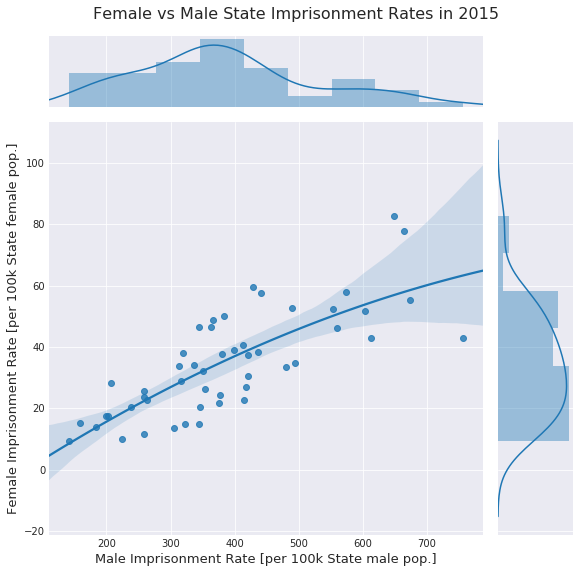

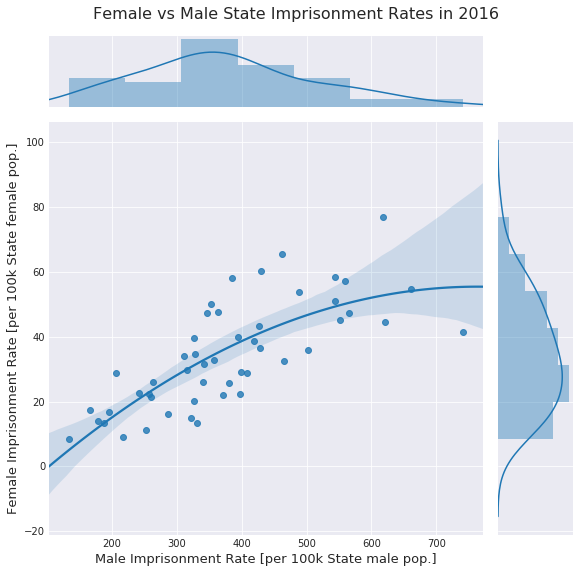

In [28]:
plot_male_v_female_by_state_sea('2015', state_sex_join_df)
plot_male_v_female_by_state_sea('2016', state_sex_join_df)

In [21]:
def plot_male_v_female_by_state(yr, df):
    mf_df = df.loc[:,(yr, ['Male_rate','Female_rate'])][yr]
    cdf = ColumnDataSource(mf_df)
    p = figure(plot_height=500, plot_width=500, tools="", toolbar_location=None,
               title="Female Imprisonment Rates vs Male Imprisonment Rates in {}"
               .format(yr))
    p.background_fill_color="#f5f5f5"
    p.grid.grid_line_color="white"
    p.xaxis.axis_label = 'Male Imprisonment Rate [per 100k State male pop.]'
    p.yaxis.axis_label = 'Female Imprisonment Rate [per 100k State female pop.]'
    p.scatter(x='Male_rate',
              y='Female_rate',
              source=cdf,
              fill_alpha=0.6,
              size=12,
              line_color=None)
    
    p.add_tools(HoverTool(
        tooltips=[
            ('State', '@Code'),
            ('Male Rate', '@Male_rate'),
            ('Female Rate', '@Female_rate'),
        ],
    ))
        
    output_notebook()
    show(p)

### Interactive Scatter Plots <a id="8"></a>

The plots above also show a regression curve that appears to deflect downward near the high end of the male imprisonment rates (mildly for 2015, and more significantly in 2016). From inspection, we see the state with the highest male imprisonment rate has a fairly average female imprisonment rate. From the choropleths above, we could (correctly) guess that this is Louisiana, but this highlights the fact that we have to cross-reference other data to identify the states, but that's inconvenient if you're just reading through this notebook on NBViewer. So I'll replicate these plots with a library that allows me to reveal more information when you hover over a data point. 

Now we can confirm the outlier data point is Louisiana. You can also see that, in 2015, Alaska (AK) had the highest female imprisonment rate, which was not revealed in the choropleth maps above because I removed Alaska and Hawaii to make the maps more compact. Comparing between years, we can see that Alaska's imprisonment rates for both men and women dropped significantly while the ratio remained fairly average. 

In [22]:
plot_male_v_female_by_state('2015', state_sex_join_df)
plot_male_v_female_by_state('2016', state_sex_join_df)

Loading BokehJS ...

Loading BokehJS ...

### Summary

Good visualizations allow us to quickly see interesting trends and outliers that would otherwise be hidden in data. For example, while it is somewhat useful to know where the bulk of prisoners are located (Texas, California, and Florida), it's more useful and interesting to see this data after we've controlled for state population. Interestingly, we see that Louisiana has a significantly higher imprisonment rate than any other state. Knowing this, we can target further research and questions about this. Per some brief independent research, I've found that Louisiana is one of two states that allow people to be [convicted of felonies when only 10 of 12 jurors agree on guilt](http://www.theadvocate.com/new_orleans/news/courts/article_85b28154-3492-11e8-bfd2-07fee9f093d2.html). This lower bar for conviction may be one of several causal factors driving Louisiana's imprisonment rate, but it will take more data and research to strengthen that hypothesis.